In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

from model import Resnet, ResidualCNNLayer, ShortcutPadLayer
from utils import load_images, unpickle, display_image
from data import Cifar10DatasetFromArray, Cifar10DatasetFromFile

In [3]:
# Images are pixel values 0-255
images, labels = load_images("../datasets/cifar-10-batches-py/data_batch_1")
label_metadata = unpickle("../datasets/cifar-10-batches-py/batches.meta")
label_names = [bytes.decode(label) for label in label_metadata["label_names"]]

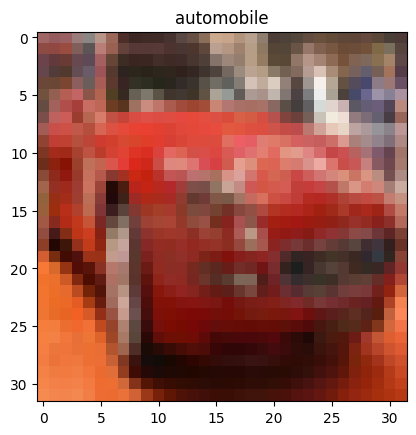

In [4]:
display_image(images[5], labels[5], label_names)

In [48]:
input_channels = 3
output_channels = [16, 32, 64]
blocks = 3
input_kernel = 3
classes = 10
shortcut_method = "projection"
batch_norm = True
block_layers=2
block_kernel_size=3

model = Resnet(
    n_classes=classes,
    in_channels=input_channels, 
    out_channels=output_channels, 
    blocks=blocks,
    input_kernel_size=input_kernel, 
    block_kernel_size=block_kernel_size,
    block_layers=block_layers,
    shortcut_method = shortcut_method,
    batch_norm=batch_norm
)
model._init_weights()
model

Resnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_blocks): ModuleList(
    (0-2): 3 x ResidualBlock(
      (layers): ModuleList(
        (0): ResidualCNNLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
        (1): ResidualCNNLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): Identity()
        )
      )
      (residual_projection): Identity()
      (final_act): ReLU()
    )
    (3): ResidualBlock(
      (layers): ModuleList(
        (0): ResidualCNNLayer(
          (conv): Conv2d(16, 32,

In [51]:
x = torch.rand(3, input_channels, 32, 32)
with torch.no_grad():
    out = model(x)
print(out.shape, torch.argmax(out, -1))

torch.Size([3, 10]) tensor([1, 1, 1])


## Data Preparation

In [ ]:
# torch.manual_seed(42)
# np.random.seed(42)

In [ ]:
train_images = np.load("../datasets/cifar-10-batches-py/train_images.npy")
train_labels = np.load("../datasets/cifar-10-batches-py/train_labels.npy")
test_images = np.load("../datasets/cifar-10-batches-py/test_images.npy")
test_labels = np.load("../datasets/cifar-10-batches-py/test_labels.npy")
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

In [ ]:
# Split training dataset
train_size = 45000
shuffled_indexes = np.random.permutation(np.arange(len(train_labels)))
train_indexes = shuffled_indexes[:train_size]
val_indexes = shuffled_indexes[train_size:]

train_images, val_images = train_images[train_indexes], train_images[val_indexes]
train_labels, val_labels = train_labels[train_indexes], train_labels[val_indexes]

In [ ]:
train_images.shape, train_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape

In [ ]:
# Transforms follow CIFAR10 preprocessing in paper https://arxiv.org/pdf/1512.03385
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.Pad(4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomCrop((32, 32))
])

In [ ]:
train_dataset = Cifar10DatasetFromArray(train_images, train_labels, transforms)
val_dataset = Cifar10DatasetFromArray(val_images, val_labels, transforms)
test_dataset = Cifar10DatasetFromArray(test_images, test_images, transforms=torchvision.transforms.ToTensor())

In [ ]:
batch_size = 128
learning_rate = 0.1
# lr scheduler manual
# early stopping
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_batch_images, test_batch_labels = next(iter(train_dl))
print(test_batch_images.shape)

with torch.no_grad():
    out = model(test_batch_images)

torch.argmax(out, dim=-1)

## Training

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    for X, y in loader:
        scores = model(X)
        _, preds = scores.data.cpu().max(1)

        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

    acc = float(num_correct) / num_samples

def train(loader_train, model, criterion, optimizer):
    model.train()
    for t, (X, y) in enumerate(loader_train):
        scores = model(X)
        loss = criterion(scores, y)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for num_epochs in [50, 5, 5]:
    print('Training for %d epochs with learning rate %f' % (num_epochs, learning_rate))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=0.9, weight_decay=0.0001)
    for epoch in range(num_epochs):
        check_accuracy(model, val_dl)
        print('Starting epoch %d / %d' % (epoch+1, num_epochs))
        train(train_dl, model, criterion, optimizer)
    learning_rate *= 0.1